In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [406]:
df = pd.read_csv('/content/sample_data/yahoo_stock.csv')

In [407]:
df['Date'] = pd.to_datetime(df['Date'])

In [408]:
print("Eksik veriler:")
print(df.isnull().sum())

Eksik veriler:
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [409]:
def split_data(dataFrame, testSize):
  position = int(round(len(dataFrame) * (1 - testSize)))
  train = dataFrame[:position]
  test = dataFrame[position:]
  return train, test, position

In [410]:
def create_features_and_labels(dataFrame, target_column, lookback):
    X, Y = [], []
    for i in range(lookback, len(dataFrame)):
        X.append(dataFrame[i - lookback:i, :])
        Y.append(dataFrame[i, target_column])
    return np.array(X), np.array(Y)

In [411]:
features = df.drop(['Date', 'Close'], axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

#Close'u ayrı ölçeklendir
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(df[['Close']])

#Ölçeklenmiş veriyi birleştir
scaled_data = np.concatenate([scaled_features, scaled_close], axis=1)

print("Scaled Data Statistics:")
print("Min:", np.min(scaled_data, axis=0))
print("Max:", np.max(scaled_data, axis=0))

Scaled Data Statistics:
Min: [0. 0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1.]


In [412]:
# %80 ve %20 olarak ayır
train_data, test_data, position = split_data(scaled_data, 0.20)

In [413]:
lookback = 20
target_column_index = df.columns.get_loc('Close')

In [414]:
#Özellik ve hedef setleri oluşturma
X_train, Y_train = create_features_and_labels(train_data, target_column_index, lookback)
X_test, Y_test = create_features_and_labels(test_data, target_column_index, lookback)

#Girdileri LSTM için uygun hale getirme
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print("Eğitim seti boyutları:", X_train.shape, Y_train.shape)
print("Test seti boyutları:", X_test.shape, Y_test.shape)

Eğitim seti boyutları: (1440, 20, 6) (1440,)
Test seti boyutları: (345, 20, 6) (345,)


In [415]:
model = Sequential()

#İlk LSTM katmanı
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

#İkinci LSTM katmanı
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))

#Çıkış katmanı
model.add(Dense(units=1))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [416]:
#Callbackler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [417]:
#Model eğit
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0082
Epoch 1: val_loss improved from inf to 0.01636, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0082 - val_loss: 0.0164
Epoch 2/30
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0443
Epoch 2: val_loss did not improve from 0.01636
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0432 - val_loss: 0.0434
Epoch 3/30
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0484
Epoch 3: val_loss did not improve from 0.01636
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0469 - val_loss: 0.0265
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0587
Epoch 4: val_loss improved from 0.01636 to 0.01485, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0580 - val_loss: 0.0148
Epoch 5/30
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0582
Epoch 5: val_loss improved from 0.01485 to 0.00834, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s

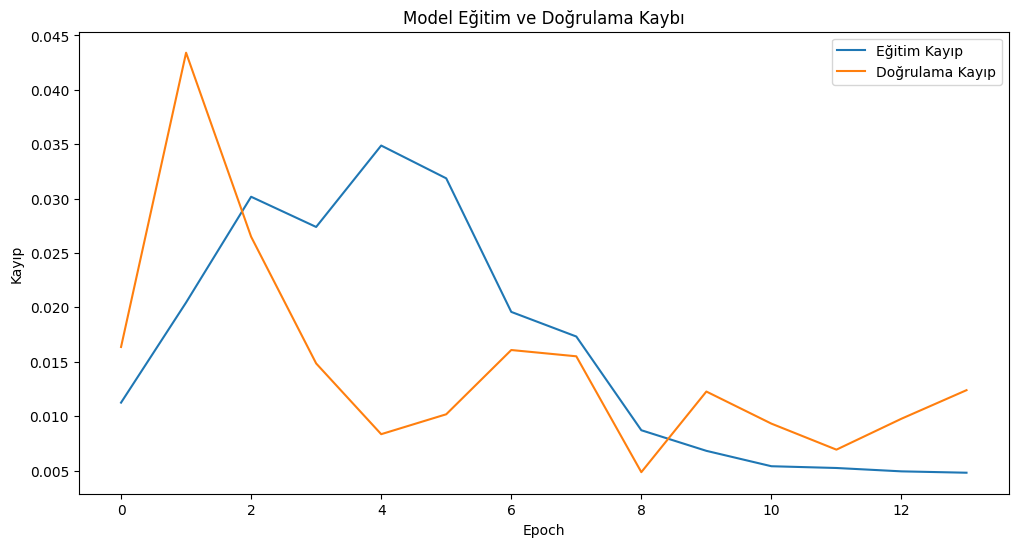

In [418]:
#Görselleştir
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Model Eğitim ve Doğrulama Kaybı')
plt.show()

In [419]:
#Eğitim seti tahminleri
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [420]:
#Eğitim tahminlerini ölçekten çıkarma
Y_train_actual = scaler_close.inverse_transform(
    np.concatenate([np.zeros_like(train_data[lookback:, :-1]), train_predict], axis=1)
)[:, -1]

#Test tahminlerini ölçekten çıkarma
Y_test_actual = scaler_close.inverse_transform(
    np.concatenate([np.zeros_like(test_data[lookback:, :-1]), test_predict], axis=1)
)[:, -1]

#Gerçek değerleri ölçekten çıkarma
Y_train_real = scaler_close.inverse_transform(
    np.concatenate([np.zeros_like(train_data[lookback:, :-1]), Y_train.reshape(-1, 1)], axis=1)
)[:, -1]

Y_test_real = scaler_close.inverse_transform(
    np.concatenate([np.zeros_like(test_data[lookback:, :-1]), Y_test.reshape(-1, 1)], axis=1)
)[:, -1]

print("Orijinal 'Close' değerleri (ilk 5):")
print(df['Close'][lookback:lookback+5].values)

print("Ölçekten çıkarılmış Y_train değerleri (ilk 5):")
print(Y_train_actual[:5])

Orijinal 'Close' değerleri (ilk 5):
[2012.36999512 2021.93994141 2043.41003418 2073.07006836 2041.89001465]
Ölçekten çıkarılmış Y_train değerleri (ilk 5):
[2165.78751468 2165.78009391 2165.75030371 2165.74175778 2165.71778095]


In [421]:
#Hata hesaplama
train_mse = mean_squared_error(Y_train_real, Y_train_actual)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(Y_train_real, Y_train_actual)

test_mse = mean_squared_error(Y_test_real, Y_test_actual)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(Y_test_real, Y_test_actual)

print(f"Eğitim MSE: {train_mse:.4f}")
print(f"Eğitim RMSE: {train_rmse:.4f}")
print(f"Eğitim MAE: {train_mae:.4f}")
print()
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Eğitim MSE: 7178.7638
Eğitim RMSE: 84.7276
Eğitim MAE: 64.0020

Test MSE: 40043.0415
Test RMSE: 200.1076
Test MAE: 171.4134


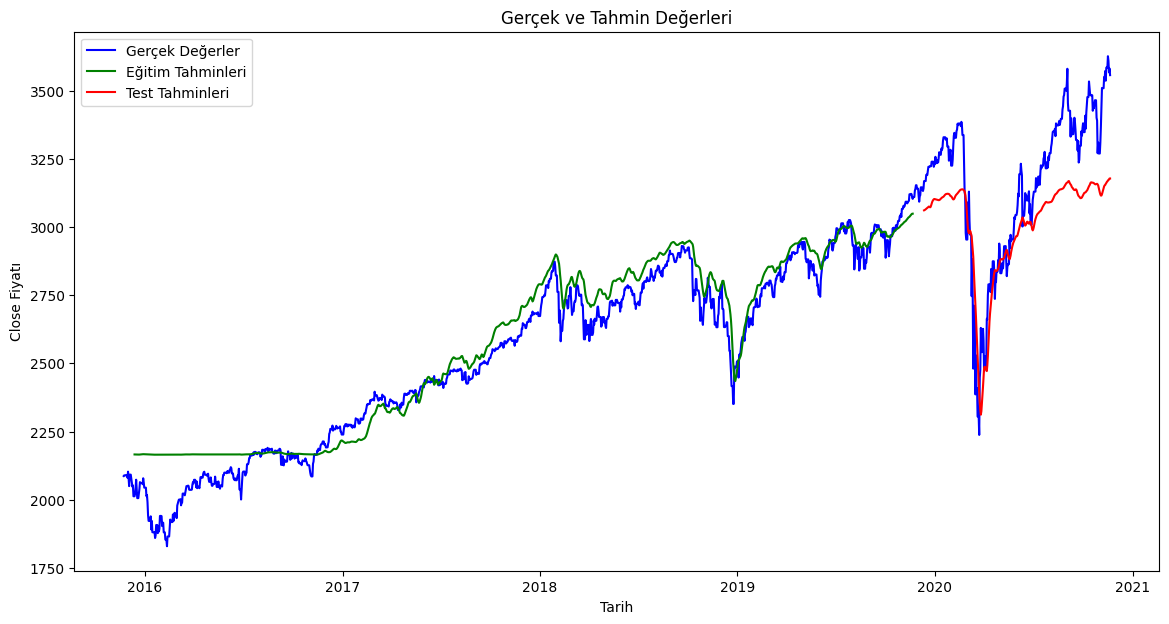

Close Sütunu İstatistikleri:
Min: 1829.0799560546875
Max: 3626.909912109375
Mean: 2647.856284313463


In [422]:
#Tahminleri ve gerçek değerleri görselleştirme
plt.figure(figsize=(14, 7))

#Gerçek değerler
plt.plot(df['Date'], df['Close'], label='Gerçek Değerler', color='blue')

#Tahmin değerleri
plt.plot(df['Date'][lookback:lookback + len(Y_train_actual)], Y_train_actual, label='Eğitim Tahminleri', color='green')
plt.plot(df['Date'][position + lookback:], Y_test_actual, label='Test Tahminleri', color='red')

plt.xlabel('Tarih')
plt.ylabel('Close Fiyatı')
plt.legend()
plt.title('Gerçek ve Tahmin Değerleri')
plt.show()

print("Close Sütunu İstatistikleri:")
print("Min:", df['Close'].min())
print("Max:", df['Close'].max())
print("Mean:", df['Close'].mean())